In [ ]:
#| default_exp s2a_delar_mup_wds_mlang
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
import io
import time
import math
import random
import dataclasses

In [ ]:
#| export
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.profiler import profile, record_function, ProfilerActivity, schedule
from fastcore.basics import store_attr
from huggingface_hub import hf_hub_download

In [ ]:
#| export
from pathlib import Path
import json
from fastprogress import progress_bar, master_bar

In [ ]:
#| export
from whisperspeech.modules import *

/opt/conda/lib/python3.10/site-packages/pyannote/audio/core/io.py:43: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")
/opt/conda/lib/python3.10/site-packages/torch_audiomentations/utils/io.py:27: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")


In [ ]:
from encodec.model import EncodecModel
import webdataset as wds
from whisperspeech.train import *

import pylab as plt
from IPython.display import Audio, HTML, display

# Semantic to acoustic token modeling

Multi-GPU training example:

    python3 -m whisperspeech.train_multi \
        --task "s2a_delar_mup_wds small --quantizers 2 --frozen_embeddings_model vqmodel-256c-dim64-4e-hyptuned-32gpu.model" \
        --input-dir "whisperspeech-s2a-512c-dim64/*.tar.gz 125000 --stoks_pad_token=512" \
        --batch-size 12 --epochs 4 \
        --tunables=--rope

### Load the dataset

In [ ]:
#| exporti
def rand(start, end):
    return random.random() * (end - start) + start

In [ ]:
#| exporti
def random_trunc(random_trunc_p, atoks_len = 2250, stoks_len = 750):
    atoks_per_second = atoks_len / 30
    def _trunc(samples):
        for s in samples:
            if random.random() < random_trunc_p:
                seconds = rand(0.3, 30)
                s['atoks.npy'] = s['atoks.npy'][:,:math.ceil(seconds * atoks_per_second)]
            s['stoks.npy'] = s['stoks.npy'][:math.ceil(s['atoks.npy'].shape[-1]/atoks_len*stoks_len)]
            yield s
    return _trunc

def pad_samples(atoks_len = 2250, stoks_len = 750, stoks_pad_token = 4096):
    def _pad(samples):
        for s in samples:
            s['stoks.npy'] = F.pad(torch.tensor(s['stoks.npy']), (1, stoks_len - s['stoks.npy'].shape[-1]-1), value=stoks_pad_token)
            s['out_stoks'] = F.pad(torch.tensor(s['stoks.npy']), (0, stoks_len - s['stoks.npy'].shape[-1]), value=stoks_pad_token)
            s['atoks.npy'] = F.pad(torch.tensor(s['atoks.npy']), (0, atoks_len - s['atoks.npy'].shape[-1]), value=-100)
            yield s
    return _pad

In [ ]:
#| exporti
def make_speaker_map(shards):
    speakers = set()
    for shard in shards:
        with open(shard+'.speakers.txt') as f: speakers = speakers.union(set(x.strip() for x in f.readlines()))
    return {id:i for i,id in enumerate(sorted(speakers))}

def speaker_id_extractor(speaker_map):
    def _extractor(samples):
        for s in samples:
            s['speaker'] = torch.tensor(speaker_map[s['__key__'].split("/")[1]])
            yield s
    return _extractor

In [ ]:
shards = [str(x) for x in Path('../ll-small-spk_emb-train/').glob('*.tar.gz')]
speakers = make_speaker_map(shards)

In [ ]:
ds = wds.WebDataset(wds.SimpleShardList(shards)).compose(
    wds.decode(),
    #wds.map_dict(**{'spk_emb.npy':np.nan_to_num}),
    speaker_id_extractor(speakers),
)

In [ ]:
for s in ds: break
s

{'__key__': 'small/92/woodbeyondtheworld_0810_librivox_64kb_mp3/woodbeyondworld_01_morris_64kb_052',
 '__url__': '../ll-small-spk_emb-train/train-000042.tar.gz',
 'atoks.npy': array([[121, 408, 408, ...,  62,  62, 408],
        [913, 913, 518, ..., 518, 424, 518],
        [786, 786, 989, ..., 786, 989,  36],
        [673, 741, 215, ..., 673, 838, 741]], dtype=int16),
 'speaker': tensor(478),
 'spk_emb.npy': array([ 1.1235610e+00,  5.8436203e+00, -1.9499685e+01,  2.8804701e+01,
         2.0494364e+01, -2.2053741e+01,  7.6806836e+00,  3.2861352e+00,
        -4.9300327e+00,  2.4251037e+00,  9.0157528e+00,  3.7315593e+00,
         2.3731998e+01, -2.5883791e+00, -7.4421372e+00,  9.5579786e+00,
         1.7692202e+00, -1.5219135e+01,  7.7783313e+00,  7.4359097e+00,
        -2.3943136e+01, -1.9906338e+01, -5.1885333e+00, -2.7640383e+01,
        -1.5681701e+01, -1.9959921e+01,  2.9790370e+00,  6.7343438e-01,
        -1.2512109e+01, -4.4835960e+01, -1.0508450e+01,  1.4617002e+00,
        -1.871

In [ ]:
keys = []
spk_ids = []
spk_embs = []
for s in progress_bar(ds, total=64):
    keys.append(s['__key__'])
    spk_ids.append(s['speaker'])
    spk_embs.append(torch.tensor(s['spk_emb.npy']))
spk_ids = torch.stack(spk_ids)
spk_embs = torch.stack(spk_embs)

In [ ]:
atoks

tensor([], size=(4, 0), dtype=torch.int16)

In [ ]:
for s in progress_bar(ds, total=5000):
    if torch.tensor(s['spk_emb.npy']).isnan().any():
        atoks = torch.tensor(s['atoks.npy'])
        print(s['__url__'], s['__key__'], atoks.shape)
#         vocoder.decode_to_notebook(torch.tensor(atoks[:,:(atoks==-100).nonzero()[0,1]]).cuda())

../ll-small-spk_emb-train/train-000042.tar.gz small/2004/chronicle_louisbourg_0711_librivox_64kb_mp3/chronicle_louisbourg_04_wood_64kb_085 torch.Size([4, 0])
../ll-small-spk_emb-train/train-000042.tar.gz small/2368/dick_sands_the_boy_captain_act_librivox_64kb_mp3/dicksands_15_verne_64kb_011 torch.Size([4, 0])
../ll-small-spk_emb-train/train-000042.tar.gz small/3657/turmoil_0908_librivox_64kb_mp3/turmoil_04_tarkington_64kb_006 torch.Size([4, 0])
../ll-small-spk_emb-train/train-000042.tar.gz small/3157/institutes_christian_religion2_1003_librivox_64kb_mp3/institutesofchristianreligion2_13_calvin_64kb_052 torch.Size([4, 0])
../ll-small-spk_emb-train/train-000042.tar.gz small/107/tramp_abroad_jg_0906_librivox_64kb_mp3/tramp_20_twain_64kb_033 torch.Size([4, 0])
../ll-small-spk_emb-train/train-000042.tar.gz small/3488/jungle_tw_0908_librivox_64kb_mp3/thejungle_25_sinclair_64kb_095 torch.Size([4, 0])
../ll-small-spk_emb-train/train-000042.tar.gz small/107/tramp_abroad_jg_0906_librivox_64kb_mp

In [ ]:
spk_embs.shape

torch.Size([64, 192])

In [ ]:
spk_embs[spk_embs.isnan().any(dim=-1)]

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan

In [ ]:
keys[16]

'small/2368/dick_sands_the_boy_captain_act_librivox_64kb_mp3/dicksands_13_verne_64kb_040'

In [ ]:
spk_embs.isnan().any(dim=-1).nonzero()

tensor([[16]])

In [ ]:
spk_ids.unique(return_counts=True)

(tensor([  6,   8,  10,  13,  50,  54,  55,  58, 104, 105, 117, 118, 122, 151,
         154, 159, 160, 162, 165, 166, 230, 249, 251, 252, 256, 304, 318, 335,
         348, 351, 436, 437, 441]),
 tensor([1, 2, 1, 5, 2, 1, 2, 2, 1, 5, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 8, 1, 3,
         1, 2, 1, 1, 1, 1, 1, 6, 1]))

In [ ]:
spk_embs_sorted = spk_embs[spk_ids.argsort()]
spk_embs_sorted = spk_embs_sorted / torch.linalg.norm(spk_embs_sorted, dim=-1, keepdim=True)
spk_ids[spk_ids.argsort()]

tensor([  6,   8,   8,  10,  13,  13,  13,  13,  13,  50,  50,  54,  55,  55,
         58,  58, 104, 105, 105, 105, 105, 105, 117, 118, 118, 118, 122, 151,
        154, 159, 160, 162, 162, 162, 165, 166, 230, 249, 249, 249, 249, 249,
        249, 249, 249, 251, 252, 252, 252, 256, 304, 304, 318, 335, 348, 351,
        436, 437, 437, 437, 437, 437, 437, 441])

In [ ]:
spk_embs.shape, spk_embs_sorted.shape

(torch.Size([64, 192]), torch.Size([64, 192]))

In [ ]:
spk_embs[7]

tensor([ 10.9192,  21.0639,  31.8316,  26.4277, -11.9478, -16.9772,   9.8850,
         14.1262, -25.3061,  17.9711,   7.4842, -13.7446,  53.2348, -14.6249,
         33.2339,  30.6775, -30.1435,  10.7685, -34.4598, -22.7670,  -1.3739,
         -7.3938,   9.4670, -54.6743, -26.5816,  12.9000,  24.8319,   5.1894,
          5.9923,   1.9081, -12.8851,  13.7233, -19.0305,  -6.9721,   8.9085,
          1.0220,  -3.3709,  -1.8594,   2.2395,   8.2434,  -1.9964,   1.6737,
        -20.1469,   9.7832,   7.2308,  -5.4863, -10.8640,  42.5644,  23.0737,
         10.5803,   7.1244, -15.5125,  25.2653,  -7.2884,   4.9547, -29.7662,
         36.5694, -25.7725, -11.3807,  14.1201,  28.5292,  12.3695, -16.9479,
         -3.4876,  10.2940,  50.5857, -10.8610,  -7.2309,  11.9308, -12.2493,
          8.0105,  42.0778,   4.5632,  22.1200,  -2.0631,  14.0806, -31.6213,
        -11.6051, -30.5606,  19.9258,   2.2697,  38.7727,  21.6024,   7.1776,
         10.6035,  -9.8909,   1.0948, -25.6604, -13.7611,  23.59

<matplotlib.image.AxesImage>

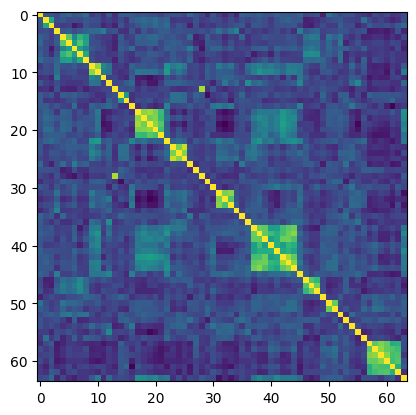

In [ ]:
plt.imshow(spk_embs_sorted @ spk_embs_sorted.T)

In [ ]:
#| export
def load_dataset(
        atoks_shard_spec:str,             # webdataset folder
        stoks_shard_dir:str,   # stoks webdataset base dir
        samples:int,           # samples per epoch
        random_trunc_p:float=0,# probability of truncating the input to less than 30 seconds
        vq_codes:int=4096,
        language:str='en',
        weight:float=1,
        validation:bool=False,
        exclude_files:str=None,
        randomize_speakers:bool=False,
    ):
    import webdataset as wds
    from whisperspeech import utils

    shards = utils.shard_glob(atoks_shard_spec)
    excludes = {x for file in exclude_files.split() for x in utils.readlines(file)} if exclude_files else set()
    
    def check_for_nan(s):
        if torch.tensor(s['spk_emb.npy']).isnan().any(): print("found NaN:", s['__key__'])
        return s
    
    def set_language(x):
        x['language'] = language
        return x
    
    same_on_all_nodes = lambda urls: urls # will only be used for validation
    ds = wds.WebDataset(shards, resampled=not validation, nodesplitter=same_on_all_nodes).compose(
        wds.decode(),
        utils.merge_in(utils.derived_dataset('maxvad-stoks', base='atoks-3kbps', suffix='', dir=stoks_shard_dir)),
        wds.map(check_for_nan),
        wds.select(lambda s: s['__key__'] not in excludes),
        wds.map_dict(**{'spk_emb.npy':np.nan_to_num}), # remove nans from the speaker embedding model
        random_trunc(random_trunc_p) if random_trunc_p > 0 else lambda x: x,
        pad_samples(stoks_pad_token=vq_codes-1),
        wds.map(set_language),
        wds.to_tuple('stoks.npy', 'atoks.npy', 'spk_emb.npy', 'language', 'out_stoks'),
        wds.shuffle(20000, initial=20000),
        wds.batched(64),
    )
    if randomize_speakers:
        rng = np.random.default_rng()
        ds = ds.compose(
            wds.map_tuple(None, None, lambda x: rng.permutation(x), None),
        )
    if validation:
        ds = ds.slice(samples // 64)
    ds.total_samples = samples
    ds.weight = weight
    
    return ds

In [ ]:
train_ds = load_dataset('wolnelektury-s2a-train/val.tar.gz', 512, stoks_pad_token=512, language='pl')

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 train_ds = load_dataset('wolnelektury-s2a-train/val.tar.gz', 512, stoks_pad_token=512, l     │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: load_dataset() got an unexpected keyword argument 'stoks_pad_token'

## Model

In [ ]:
import pylab as plt
import fastprogress
import IPython
import numpy as np

class CMLMVisual:
    """Visualize training progress"""
    def __init__ (self, model, masterbar, total_steps):
        self.model = model
        self.masterbar = masterbar
        self.total_steps = total_steps
        self.epochs = total_steps // masterbar.main_bar.total
        
        gs = plt.GridSpec(3, 1, height_ratios=[2,2,1])
        graph_fig = plt.figure(figsize=(10,6))
        self.graph_fig = graph_fig
        self.loss_p = graph_fig.add_subplot(gs[0])
        self.acc_p = graph_fig.add_subplot(gs[1], sharex=self.loss_p)
        self.acc_p.tick_params('x', labelbottom=False)
        self.lr_p = graph_fig.add_subplot(gs[2], sharex=self.loss_p)
        self.lr_p.tick_params('x', labelbottom=False)
        self.graph_out = None
        
        self.its = []
        self.train_losses = []
        self.val_losses = []
        self.lr_history = []
        self.acc = np.nan
        self.acc_history = []
        self.pacc_history = []
            
    def show(self):
        self.start_t = time.time()
        self.masterbar.write(["samples", "train", "val", "time"], table=True)
        self.graph_out = display(self.graph_fig, display_id=True)
        self.acc_out = display(IPython.display.HTML(''), display_id=True)
    
    def hide(self):
        if self.graph_out is not None:
            self.graph_out.update(IPython.display.HTML(''))
    
    def plot(self):
        loss_p, acc_p, lr_p = self.loss_p, self.acc_p, self.lr_p
        loss_p.clear()
        loss_p.plot(self.its, self.train_losses)
        loss_p.plot(self.its, self.val_losses)
        loss_p.set_xlim(0, self.total_steps)
        loss_p.set_yscale('log')
        acc_p.clear()
        for k in self.acc_history[-1].keys():
            acc_p.plot(self.its, [x[k] for x in self.acc_history], ':')
#         acc_p.plot(self.its, np.stack(self.pacc_history), label=range(len(self.pacc_history[0])))
        lr_p.clear()
        lrs = np.array(self.lr_history)
        lr_p.plot(self.its, lrs)
        self.graph_out.update(self.graph_fig)
    
    def add_data(self, it, lr, train_loss, val_los):
        self.its.append(it)
        self.train_losses.append(train_loss)
        self.val_losses.append(val_los)
        self.lr_history.append(lr)
        metrics = self.model.get_metrics()
        self.acc_history.append(metrics)
#         self.acc_out.update(f"Accuracy: {self.entropy_history[-1]:.2f}")
#         self.pacc_history.append((self.model.pval_true / self.model.pval_total).cpu().numpy())
#         if self.acc_history:
        html  = "<h5>Accuracies:</h5><table>"
        html += "<thead>"+(''.join([f"<td>{k}<td>" for k,x in metrics.items()]))+"</thead>"
        html += "<tr>"+(''.join([f"<td>{x*100:.1f}%<td>" for k,x in metrics.items()]))+"</tr>"
        html += "</table>"
        self.acc_out.update(IPython.display.HTML(html))
        self.plot()

    def add_table_row(self, it, avg_train_loss, val_loss):
        elapsed_t = time.time() - self.start_t
        self.masterbar.write([it, f"{avg_train_loss:.5f}", f"{val_loss:.5f}", fastprogress.core.format_time(elapsed_t)], table=True)
    
    def on_iter(self, bar, it, avg_train_loss, val_loss):
        epoch = math.ceil(it / self.total_steps * self.epochs)
        bar.comment = f"#{epoch}/{self.epochs} loss: {avg_train_loss:.3f} / {val_loss:.3f}"

In [ ]:
femb = FlexEmbeddings(2, 3, 1).half()
with torch.no_grad():
    femb.main.weight[:] = 0
    femb.main.weight[:,:2] = torch.eye(2)
    femb.special.weight[:] = torch.tensor([0,0,1])
femb.main.weight, femb.special.weight

(Parameter containing:
 tensor([[1., 0., 0.],
         [0., 1., 0.]], dtype=torch.float16, requires_grad=True),
 Parameter containing:
 tensor([[0., 0., 1.]], dtype=torch.float16, requires_grad=True))

In [ ]:
embs = femb(torch.tensor([[0,2,1,0]]))
embs

tensor([[[1., 0., 0.],
         [0., 0., 1.],
         [0., 1., 0.],
         [1., 0., 0.]]], dtype=torch.float16, grad_fn=<IndexPutBackward0>)

In [ ]:
embs += femb(torch.tensor([[0]]))

In [ ]:
femb.unembed(embs.float())

torch.Size([1, 4, 2])
torch.Size([1, 4, 1])
torch.Size([1, 4, 3])


tensor([[[2., 0., 0.],
         [1., 0., 1.],
         [1., 1., 0.],
         [2., 0., 0.]]], grad_fn=<CatBackward0>)

In [ ]:
amodel = EncodecModel.encodec_model_24khz()

In [ ]:
amodel.quantizer.vq.layers[0].codebook

tensor([[ 5.3395, 13.1336, -3.3514,  ...,  2.2543, -4.5506,  3.7425],
        [ 2.5562, 13.8098, -5.7393,  ...,  0.4362, -2.5406,  1.5548],
        [ 3.9551, 12.0306, -6.5480,  ...,  1.6861, -5.3334,  1.3966],
        ...,
        [ 2.3868, 11.8062, -3.8374,  ..., -0.3132, -3.2393,  1.8929],
        [ 1.1349, 11.0860, -2.8491,  ..., -0.6624, -1.4591,  1.9885],
        [ 3.7719, 12.2859, -3.8640,  ...,  1.1728, -3.3949,  3.3238]])

In [ ]:
#| export
class DelSumEmbedding(nn.Module):
    def __init__(self, n_head=6, head_width=64, atoks_width=None, length=2250, codes=1024, quantizers=8, pos_embs=None):
        super().__init__()
        self.length = length
        width = n_head * head_width
        if atoks_width is None: atoks_width = width
        self.width = width
        self.quantizers = quantizers

        emb = None
        embs = []
        for _ in range(quantizers):
            emb = FlexEmbeddings(codes, width, special_codes=2, frozen_width=atoks_width,
                                 special_embedding=emb and emb.special)
            embs.append(emb)
        self.embeddings = nn.ModuleList(embs)
        if pos_embs is not None:
            self.register_buffer("positional_embedding", pos_embs)

    def forward(self, toks, xenc):
        with record_function("embeddings"):
            b,_,n = toks.shape
            newn = min(n, self.length)

            embs = torch.zeros((b,newn,self.width), dtype=xenc.dtype, device=xenc.device)
            for i in range(self.quantizers):
                embs[:, :] += self.embeddings[i](toks[:,i,:])
            
            x = embs.to(xenc.dtype)
        return x

In [ ]:
#| export
class DelSumHead(nn.Module):
    def __init__(self, quantizers=8, n_head=6, head_width=64):
        super().__init__()
        self.width = n_head * head_width
        self.quantizers = quantizers
        self.splitter = nn.Sequential(
            nn.Linear(self.width, self.width * quantizers),
            nn.GELU(),
        )

    def forward(self, x, embeddings=None):
        b, newn, _ = x.shape
        with record_function("splitter"):
            split = self.splitter(x).view(b,newn,self.quantizers,self.width)
        with record_function("unembed"):
            logits = torch.stack([embeddings[q].unembed(split[:,:,q]) for q in range(self.quantizers)], dim=1)
        return logits
        
def rand(start, end):
    return random.random() * (end - start) + start
    
@dataclasses.dataclass
class Tunables:
    init_std :float = 9
    embeddings_std :float = 0.2
    embeddings_lr_scale: float = 10
    output_mult :float = 5.6
    # FIXME: try separate mults for self and cross attention
    query_mult :float = .3
    encoder_depth_ratio :float = 0.25
    linear_heads :bool = False
    rope :bool = True
    
    lr0 :float = 3e-3
    clip_gradient_norm :float = 2
    weight_decay :float = 1e-3
    warmup_steps :float = 2000

    random :bool = False

    def __post_init__(self):
        # randomize the hyperparams if requested
        if self.random:
            self.init_std = 2*10**rand(0,1)
            self.embeddings_std = 10**rand(-1.7,-0.22)
            self.embeddings_lr_scale = 2**rand(2,4)
            self.output_mult = 2**rand(1.5,3)
            self.query_mult = 2**rand(-3,-1.3)
            self.encoder_depth_ratio = random.choice([0.25,0.5])
            self.linear_heads = False
            self.rope = True
            
            self.lr0 = 3e-3
            self.clip_gradient_norm = 10**rand(-1,1)
            self.warmup_steps = 100*(10**rand(1.18,1.3))
            
    @staticmethod
    def upgrade(args):
        args = {k:v for k,v in args.items()}
        def old_default(name, value):
            if name not in args: args[name] = value
        old_default('rope', False)
        old_default('linear_heads', True)
        return args
            
class SADelARTransformer(nn.Module):
    def __init__(self, depth=3, ctx_n=2250,
                 stoks_len=750, stoks_codes=4097, stoks_width=None,
                 spk_width=None,
                 atoks_width=None,
                 n_head=3, head_width=64, ffn_mult=4,
                 quantizers=8, speaker_map={"1":0}, tunables=Tunables()):
        super().__init__()
        self.quantizers = quantizers
        self.codes = 1024
        width = n_head * head_width
        store_attr("depth,ctx_n,stoks_len,stoks_codes,stoks_width,spk_width,atoks_width,n_head,head_width,ffn_mult,quantizers,speaker_map")
        self.width = width
        self.base_width = 3 * head_width
        self.tunables = tunables
        
        if stoks_width is None: stoks_width = width
        if spk_width is None: spk_width = width
        self.emb_factor = width != stoks_width
        self.spk_factor = width != spk_width

        if tunables.rope:
            self.positional_embeddings = None
        else:
            self.register_buffer('positional_embeddings', sinusoids(ctx_n, width))
        
#         self.speaker_embedding = nn.Embedding(len(speaker_map), spk_width)
        self.semantic_embedding = nn.Embedding(stoks_codes, stoks_width)
        if self.emb_factor:
            self.emb_to_hidden = nn.Linear(stoks_width, width)
            self.hidden_to_emb = nn.Linear(width, stoks_width)
        
        if self.spk_factor:
            self.spk_to_hidden = nn.Linear(spk_width, width)

        qk_scale = self.tunables.query_mult * 8 / math.sqrt(head_width)
        
        encoder_depth = int(depth * 2 * tunables.encoder_depth_ratio)
        decoder_depth = depth * 2 - encoder_depth
        self.encoder = nn.Sequential(*[
            ResidualAttentionBlock(width, n_head, qk_scale=qk_scale, ffn_mult=ffn_mult, rope=tunables.rope) for _ in range(encoder_depth)
        ]) # FIXME: enclm requires causal attention here
        self.ln_post = LayerNorm(width)

        self.embds = DelSumEmbedding(
            pos_embs=self.positional_embeddings, length=ctx_n,
            n_head=n_head, head_width=head_width, atoks_width=atoks_width,
            quantizers=quantizers,
        )
        self.decoder = BaseDecoder(qk_scale=qk_scale, length=ctx_n,
                                     n_head=n_head, width=n_head * head_width, 
                                     ffn_mult=ffn_mult, depth=decoder_depth,
                                     rope=tunables.rope)
        self.head = DelSumHead(n_head=n_head, head_width=head_width, quantizers=quantizers)
        for l in self.decoder.layers:
            l.cross_attn.key_subsampling = 3
#         for l in self.encoder:
#             l.attn.key_subsampling = 3
#             l.attn.query_subsampling = 3
        
        self.register_buffer('val_true', torch.zeros(self.quantizers).cuda())
        self.register_buffer('val_total', torch.zeros(self.quantizers).cuda())
        self.apply(self.init_transformer)

    def setup(self, device):
        pass
        
    def load_frozen_semantic_embeddings(self, vqmodel):
        with torch.no_grad():
            self.semantic_embedding.weight[:] = vqmodel.rq.layers[0]._codebook.embed[0]
            self.semantic_embedding.lr_scale = 0

    def load_frozen_acoustic_embeddings(self, amodel):
        for i in range(self.quantizers):
            self.decoder.embeddings[i].set_frozen_embeddings(amodel.quantizer.vq.layers[i].codebook)
            
    def init_transformer(self, m):
        if isinstance(m, LinearHead):
            m.no_weight_decay = True
            torch.nn.init.constant_(m.weight, 0)
        elif isinstance(m, QueryHead):
            m.lr_scale = 1/(m.weight.shape[1] / self.base_width)
            torch.nn.init.constant_(m.weight, 0)
        elif isinstance(m, nn.Embedding):
            m.no_weight_decay = True
            m.lr_scale = self.tunables.embeddings_lr_scale
            std = self.tunables.embeddings_std
            torch.nn.init.trunc_normal_(m.weight, std=std, a=-3*std, b=3*std)
#         elif isinstance(m, EmbeddingProjector):
#             m.lr_scale = self.tunables.embeddings_lr_scale #1/(m.weight.shape[1] / self.base_width)
#             m.lr_scale = 2/(m.weight.shape[1] / self.base_width)
#             std = self.tunables.init_std / m.weight.shape[1]
#             torch.nn.init.trunc_normal_(m.weight, std=std, a=-3*std, b=3*std)
        elif isinstance(m, nn.Linear):
            m.lr_scale = 1/(m.weight.shape[1] / self.base_width)
            std = self.tunables.init_std / m.weight.shape[1]
            torch.nn.init.trunc_normal_(m.weight, std=std, a=-3*std, b=3*std)
            if m.bias is not None:
                torch.nn.init.trunc_normal_(m.bias, std=std, a=-3*std, b=3*std)
        elif isinstance(m, nn.LayerNorm):
            m.no_weight_decay = True
            torch.nn.init.constant_(m.bias, 0)
            torch.nn.init.constant_(m.weight, 1)

    def embed_stoks(self, Stoks):
        b,n = Stoks.shape
        if self.stoks_len == 1500:
            # converts 50 toks/s to 75 toks/s by adding padding between every two tokens
            x = Stoks.reshape(b,n//2,2)
            x = x.repeat_interleave(2, -1)[:,:,:3]
            x[:,:,1] = 1024
            x = x.reshape(b,n//2*3)
        else:
            # it's a lot easier with 25 toks/s
#             x = Stoks.repeat_interleave(3, -1)
            x = Stoks
        # embed semantic tokens
        Sembs = self.semantic_embedding(x.to(torch.long))
        if self.emb_factor:
            Sembs = self.emb_to_hidden(Sembs)
        return Sembs

    def _encoder(self, semb, positions):
        x = semb
        for l in self.encoder: x = l(x, positions)
        return self.ln_post(x)
    
    def run_encoder(self, Stoks, speakers):
        semb = self.embed_stoks(Stoks)
        with record_function("encoder"):
            if self.positional_embeddings is not None: semb = semb + self.positional_embeddings
            positions = torch.arange(0, semb.shape[1], device=semb.device)
            xenc = self._encoder(semb, positions)
        if self.training:
            enc_logits = (self.hidden_to_emb(xenc) @ self.semantic_embedding.weight.to(xenc.dtype).T).float()
            enc_logits = enc_logits * self.tunables.output_mult / (self.width / self.base_width)
        else:
            enc_logits = None
#         print(xenc.shape, speakers.shape)
        spk_embs = F.normalize(speakers, dim=-1) # use extracted embeddings
        if self.spk_factor: spk_embs = self.spk_to_hidden(spk_embs)
        return xenc + spk_embs.unsqueeze(1), positions, enc_logits

    def forward(self, Stoks, Atoks, speakers, langs=None, out_stoks=None, noloss=False, xenc=None, xenc_positions=None, atoks_positions=None):
        if xenc is None:
            Atoks = Atoks.to(torch.long)
            out_stoks = out_stoks.to(torch.long)
            Atoks_gt = Atoks.clone()
            Atoks_gt[Atoks == -100] = 1024
            xenc, enc_logits = self.run_encoder(Stoks, speakers)
        else:
            Atoks_gt = Atoks
        with record_function("decoder"):
            embs = self.embds(Atoks, xenc)
            if atoks_positions is None: atoks_positions = torch.arange(0, embs.shape[1], device=embs.device)
            x = self.decoder(embs, atoks_positions, xenc, xenc_positions)
            logits = self.head(x, embeddings=self.embds.embeddings)
            logits *= self.tunables.output_mult / (self.width / self.base_width)
            
        if noloss:
            return logits

        with record_function("loss"):
            N = Atoks.shape[-1]
            loss = 0
            for i in range(self.quantizers):
                loss += F.cross_entropy(logits[:,i,i:].reshape(-1,logits.shape[-1]), Atoks[:,i,:N-i].reshape(-1))
                if self.training and i == 0:
                    loss *= 5
            loss /= self.quantizers
            if self.training:
                loss += 0.1 * F.cross_entropy(enc_logits.transpose(-1,-2), out_stoks)

        if not self.training:
            for i in range(self.quantizers):
                Atoks_i = Atoks[:,i,:N-i]
                valid_Atoks = Atoks_i != -100
                self.val_true[i] += (logits[:,i,i:].argmax(-1)[valid_Atoks] == Atoks_i[valid_Atoks]).float().sum()
                self.val_total[i] += valid_Atoks.float().sum()

        return logits, loss

    def get_metrics(self):
        metrics = {
            f'acc_{i}':x.item() for i,x in enumerate(self.val_true / self.val_total)
        }
        self.val_true[:] = 0
        self.val_total[:] = 0
        return metrics

    #
    # inference
    #
    @classmethod
    def load_model(cls, ref="collabora/whisperspeech:s2a-q4-small-en+pl.model",
                   repo_id=None, filename=None, local_filename=None):
        if repo_id is None and filename is None and local_filename is None:
            if ":" in ref:
                repo_id, filename = ref.split(":", 1)
            else:
                local_filename = ref
        if not local_filename:
            local_filename = hf_hub_download(repo_id=repo_id, filename=filename)
        spec = torch.load(local_filename)
        if '_extra_state' not in spec['state_dict'] and 'speaker_map' in spec['config']: spec['state_dict']['_extra_state'] = { 'speaker_map': spec['config']['speaker_map'] }
        model = cls(**spec['config'], tunables=Tunables(**Tunables.upgrade(spec['tunables'])))
        model.load_state_dict(spec['state_dict'])
        model.eval()
        return model
    
    def get_extra_state(self):
        return { 'speaker_map': self.speaker_map }
    
    def set_extra_state(self, st):
        self.speaker_map = st['speaker_map']

    def load_checkpoint(self, local_filename_or_obj):
        if isinstance(local_filename_or_obj, (str, Path)):
            spec = torch.load(local_filename, map_location='cpu')
        else:
            spec = local_filename_or_obj
        assert 'pytorch-lightning_version' in spec, 'not a valid PyTorch Lightning checkpoint'
        state_dict = {k.replace('model.', ''):v
                      for k,v in spec['state_dict'].items()}
        self.load_state_dict(state_dict)
        return self
    
    def save_model(self, fname):
        torch.save(dict(config = self.__stored_args__,
                        tunables = dataclasses.asdict(self.tunables),
                        state_dict = self.state_dict()), fname)

    def switch_dtypes(self, dtype=torch.float16):
        self.dtype = dtype
        for n,m in self.named_modules():
            # convert every leaf layer apart from the LayerNorms
            if isinstance(m, (nn.Linear, nn.Embedding)):
                m.to(dtype)
            # take care of buffers ([kv]_cache, masks) that are not in the leaf layers
            for bn,b in m.named_buffers(recurse=False):
                setattr(m,bn,b.to(dtype))

    def optimize(self, max_batch_size=1, dtype=torch.float16, torch_compile=True):
        for emb in self.embds.embeddings:
            emb.convert_for_eval()
        for l in self.encoder:
            l.attn.convert_for_eval()
        for l in self.decoder.layers:
            l.attn.convert_for_eval()
            l.cross_attn.convert_for_eval()
            l.setup_kv_cache(max_batch_size, self.ctx_n, self.stoks_len)
        self.switch_dtypes(dtype)
        if torch_compile:
            self.generate_next = torch.compile(self.generate_next, mode="reduce-overhead", fullgraph=True)

    @property
    def device(self):
        return next(self.parameters()).device

    # from https://github.com/pytorch-labs/gpt-fast/blob/main/generate.py
    def multinomial_sample_one_no_sync(self, probs_sort): # Does multinomial sampling without a cuda synchronization
        q = torch.empty_like(probs_sort).exponential_(1)
        return torch.argmax(probs_sort / q, dim=-1, keepdim=True).to(dtype=torch.int)

    def logits_to_probs(self, logits, T=1.0, top_k=None):
        logits = logits / max(T, 1e-5)

        if top_k is not None:
            v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
            pivot = v.select(-1, -1).unsqueeze(-1)
            logits = torch.where(logits < pivot, -float("Inf"), logits)
        probs = torch.nn.functional.softmax(logits, dim=-1)
        return probs

    def sample(self, logits, T=1.0, top_k=None):
        probs = self.logits_to_probs(logits[0,:,-1], T, top_k)
        idx_next = self.multinomial_sample_one_no_sync(probs)
        return idx_next

    def generate_one(self, toks, positions, langs, xenc, xenc_positions, T, top_k):
        probs = self(None, toks, None, langs, noloss=True, xenc=xenc, xenc_positions=xenc_positions, atoks_positions=positions)
        return self.sample(probs, T, top_k)

    def generate_next(self, *args, **kwargs):
        return self.generate_one(*args, **kwargs)
    
    @torch.no_grad()
    def generate(self, stoks, speakers, langs=None, N=None, T=0.7, top_k=None, show_progress_bar=True, step=None, subsample_enc=False):
        dev = self.device
        N = N or len(stoks) * 3
        stoks = F.pad(stoks.to(dev), (1, self.stoks_len - len(stoks)-1), value=self.stoks_codes-1).unsqueeze(0)
        speakers = speakers.to(device=dev, dtype=self.dtype)
        toks = torch.full((1,self.quantizers,2250), self.codes+1, dtype=torch.long, device=dev)
        it = range(1,min(N,2250-1))
        if show_progress_bar: it = progress_bar(it)
        with record_function("encode"):
            xenc, xenc_positions, _ = self.run_encoder(stoks, speakers)
            toks_positions = torch.arange(N, device=dev)
        with record_function("prefill"):
            toks[0,0,1] = self.generate_one(toks[:,:,:1], toks_positions[:1], langs, xenc, xenc_positions, T, top_k)[0,0]
        with torch.backends.cuda.sdp_kernel(enable_flash=False, enable_mem_efficient=False, enable_math=True):
            for i in it:
                with record_function("generate_one"):
                    toks[0,:i+1,i+1] = self.generate_next(toks[:,:,i:i+1], toks_positions[i:i+1], langs, xenc, xenc_positions, T, top_k)[:i+1,0]

                # for profiling, debugging or early exit
                if step is not None: step()
        # shift tokens
        toks = toks[:,:,1:N]
        for j in range(self.quantizers):
            toks[0, j] = torch.roll(toks[0, j], -j)
        return toks[0]

In [ ]:
#| exporti
def _make_model(size:str, quantizers:int=4, tunables:Tunables=Tunables(), **kwargs):
    kwargs = dict(quantizers=quantizers, tunables=tunables, **kwargs)
    if size == 'micro':
        return SADelARTransformer(depth=4, n_head=3, ffn_mult=2, **kwargs)
    if size == 'tiny-narrow':
        return SADelARTransformer(depth=4, n_head=6, ffn_mult=1, **kwargs)
    if size == 'tiny':
        return SADelARTransformer(depth=4, n_head=6, **kwargs)
    if size == 'base':
        return SADelARTransformer(depth=6, n_head=8, **kwargs)
    if size == 'base-deep':
        return SADelARTransformer(depth=9, n_head=8, **kwargs)
    if size == 'base-wide':
        return SADelARTransformer(depth=6, n_head=12, **kwargs)
    if size == 'small/2':
        return SADelARTransformer(depth=9, n_head=12, **kwargs)
    if size == 'small':
        return SADelARTransformer(depth=12, n_head=12, **kwargs)
    if size == 'medium':
        return SADelARTransformer(depth=24, n_head=16, **kwargs)

def make_model(size:str, quantizers:int=4, frozen_embeddings_model:str=None, frozen_acoustic_embeddings:bool=False, spk_width:int=None, tunables:Tunables=Tunables(), dataset=None):
    from encodec.model import EncodecModel
    from whisperspeech import vq_stoks

    amodel = EncodecModel.encodec_model_24khz() if frozen_acoustic_embeddings else None
    vqmodel = vq_stoks.RQBottleneckTransformer.load_model(frozen_embeddings_model) if frozen_embeddings_model else None
    model = _make_model(size, quantizers, tunables,
                        spk_width=spk_width,
                        atoks_width=amodel and amodel.quantizer.vq.layers[0]._codebook.embed.shape[-1],
                        stoks_codes=vqmodel.vq_codes+1, stoks_width=vqmodel.rq.layers[0]._codebook.embed[0].shape[-1])
    if vqmodel: model.load_frozen_semantic_embeddings(vqmodel)
    if amodel: model.load_frozen_acoustic_embeddings(amodel)
    return model

In [ ]:
%pdb

Automatic pdb calling has been turned ON


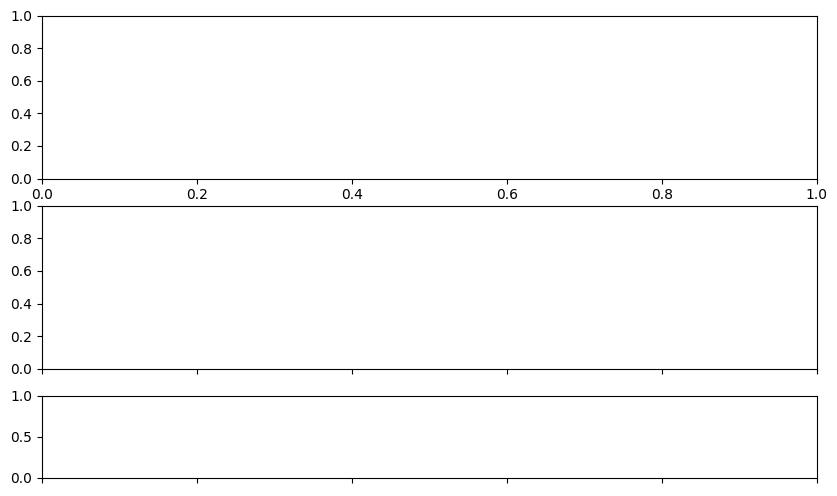

samples,train,val,time


In [ ]:
# baseline
train_ds = load_dataset('libri')
model = make_model('micro', quantizers=2, frozen_embeddings_model='vqmodel-medium-en+pl-512c-dim64.model').cuda()
train(f"s2a-new", model, train_ds, train_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)

samples,train,val,time
20000,3.26710,3.48323,03:31


found NaN: small/3488/jungle_tw_0908_librivox_64kb_mp3/thejungle_04_sinclair_64kb_087
found NaN: small/2628/turmoil_0908_librivox_64kb_mp3/turmoil_23_tarkington_64kb_053
found NaN: small/3488/jungle_tw_0908_librivox_64kb_mp3/thejungle_07_sinclair_64kb_078


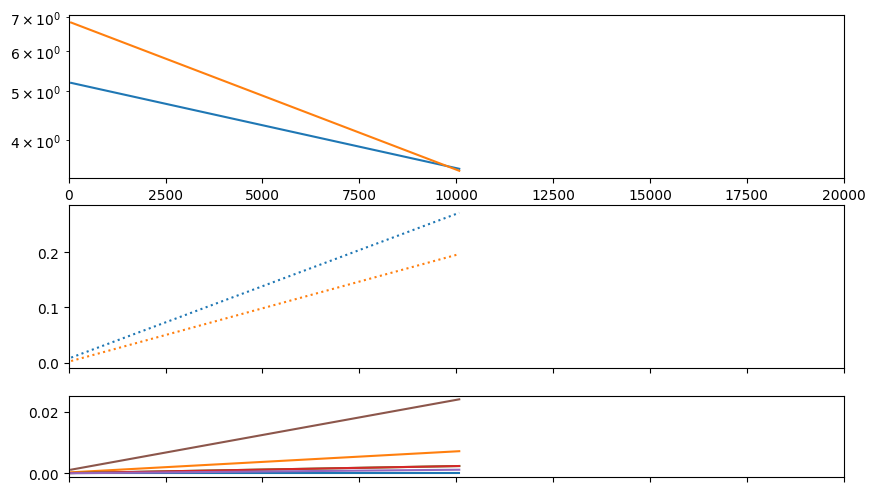

In [ ]:
# baseline
model = make_model('micro', quantizers=2, frozen_embeddings_model='old-models/vqmodel-512c-dim64-4e-hyptuned-32gpu.model', dataset=small_ds).cuda()
train(f"s2a-new", model, small_ds, small_val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)

192 32 4097


samples,train,val,time
50016,3.43991,3.64125,03:15
100000,3.26612,3.39851,06:13
150016,3.15735,3.30149,09:10
160000,3.16834,3.29321,09:45


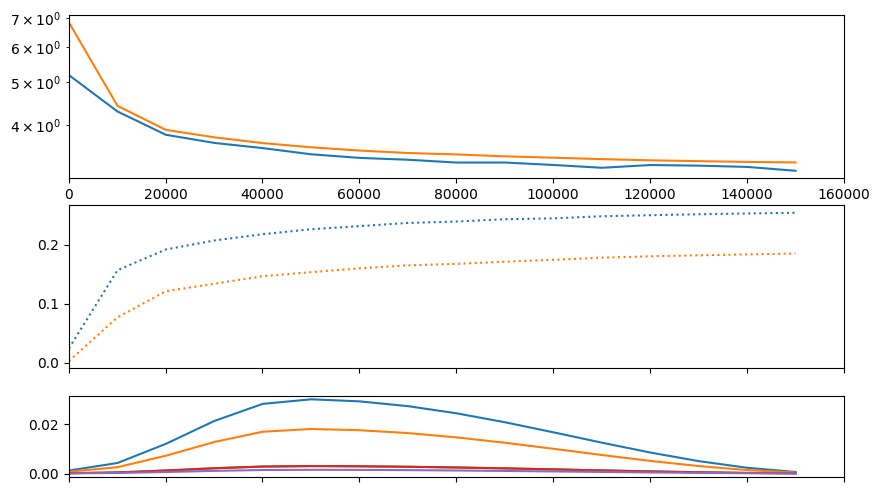

In [ ]:
# baseline
model = make_model('micro', quantizers=2, frozen_embeddings_model='vqmodel-4e-hyptuned-32gpu.model', dataset=train_ds).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)

192 32 4097


samples,train,val,time
50016,3.42783,3.63384,04:32
100000,3.24147,3.39155,08:49
150016,3.15337,3.29065,13:05
160000,3.17545,3.28113,13:56


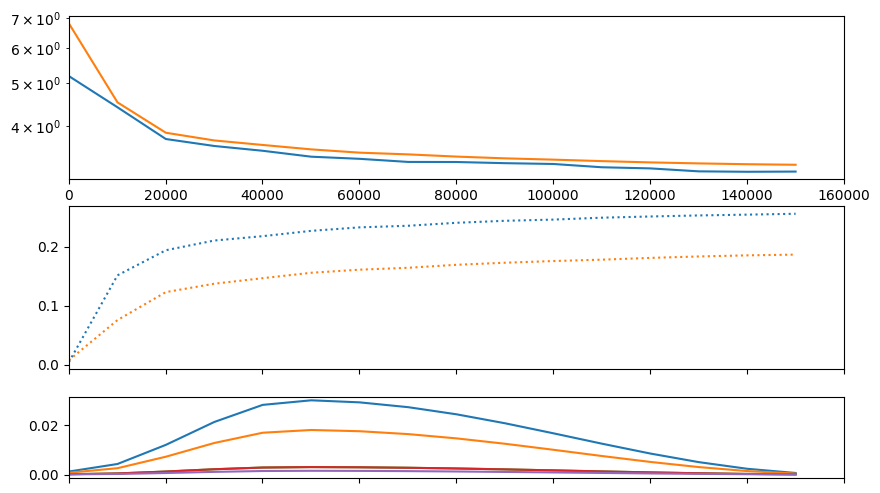

In [ ]:
# crossattn
model = make_model('micro', quantizers=2, frozen_embeddings_model='vqmodel-4e-hyptuned-32gpu.model', dataset=train_ds).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)

192 32 4097


samples,train,val,time
50016,3.30626,3.51887,03:17
100000,3.10474,3.23221,06:18
150016,3.00842,3.13535,09:18
160000,3.01038,3.12537,09:54


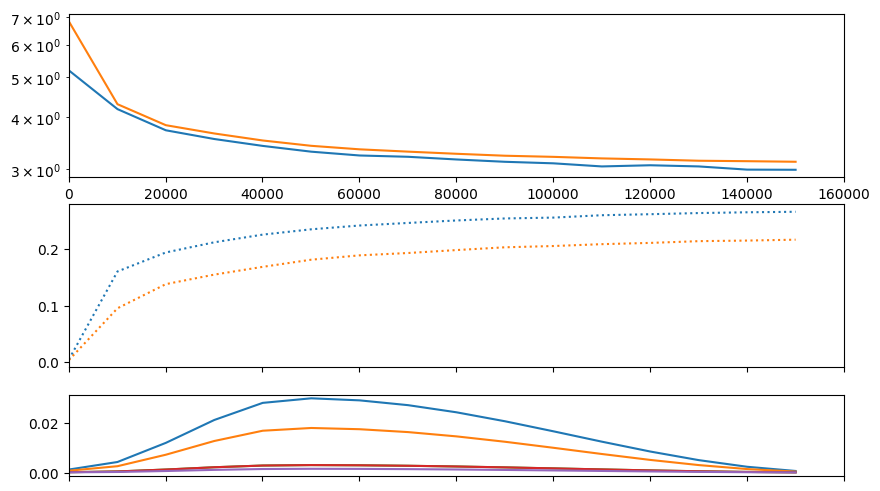

In [ ]:
# crossattn, emb 2Q
model = make_model('micro', quantizers=2, frozen_embeddings_model='vqmodel-4e-hyptuned-32gpu.model', dataset=train_ds).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)

192 32 4097


samples,train,val,time
50016,3.31771,3.37854,04:22
100000,3.11682,3.12633,08:44
150016,3.02503,3.01944,13:05
160000,3.01330,3.01079,13:58


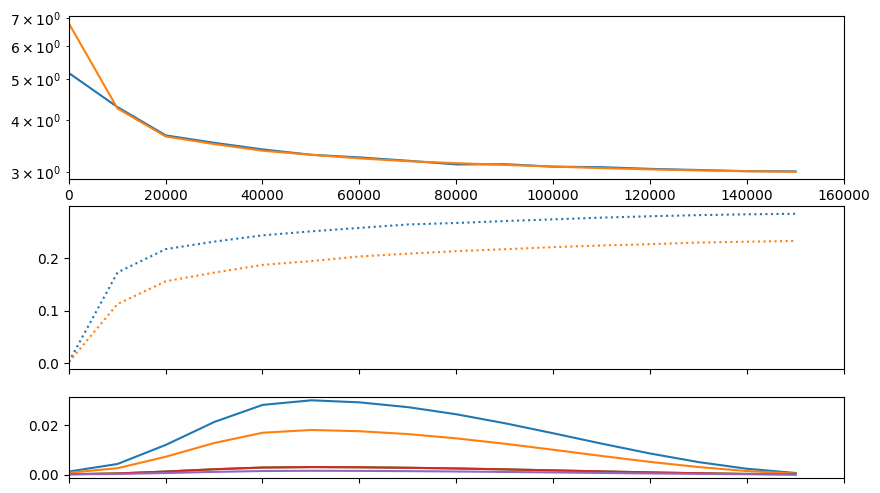

In [ ]:
# crossattn, emb 2Q, 400+ shards
model = make_model('micro', quantizers=2, frozen_embeddings_model='vqmodel-4e-hyptuned-32gpu.model', dataset=train_ds).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)

192 32 4097


samples,train,val,time
50016,3.06899,3.21095,04:24
100000,2.84990,2.93317,08:47
150016,2.77312,2.81134,13:10
180000,2.73082,2.77786,15:48


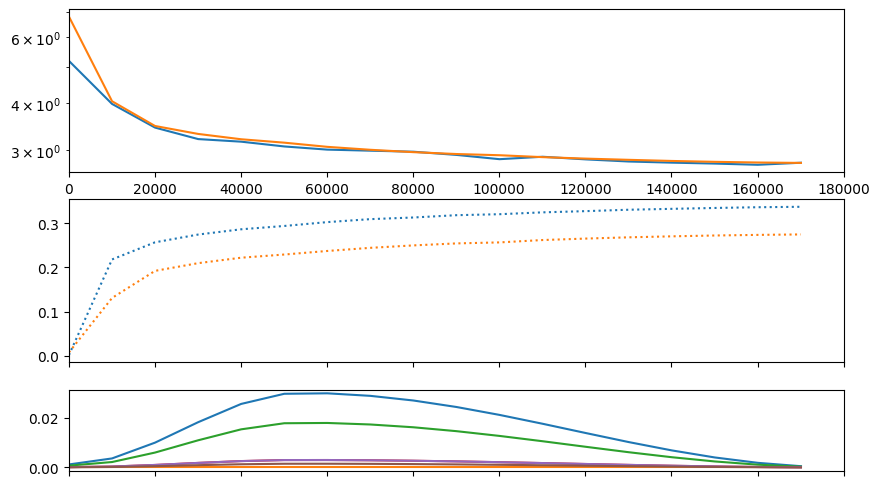

In [ ]:
# crossattn, emb 2Q, 400+ shards
train_ds, val_ds = load_datasets('s2a-small/*.tar.gz', samples=180000)
model = make_model('micro', quantizers=2, frozen_embeddings_model='vqmodel-4e-hyptuned-32gpu.model', dataset=train_ds).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)

192 32 4097


samples,train,val,time
50016,3.10401,3.20805,04:24
100000,2.83302,2.92958,08:48
150016,2.75915,2.80805,13:12
180000,2.74166,2.77508,15:49


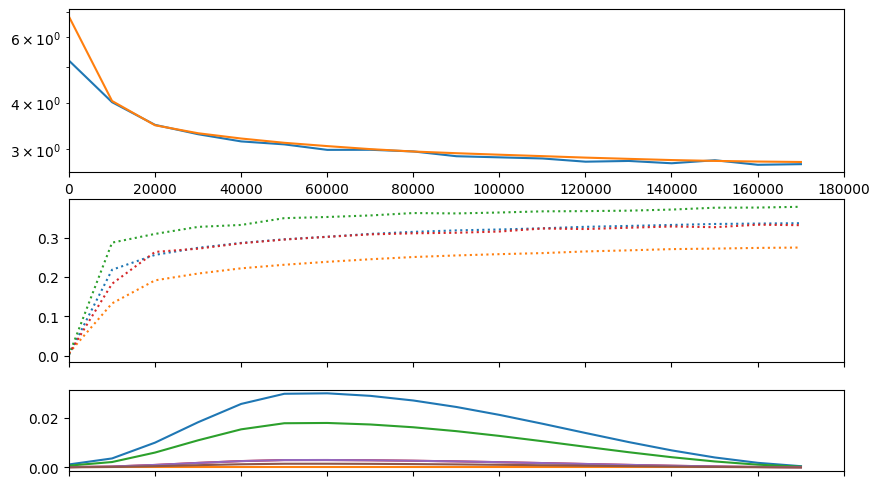

In [ ]:
# crossattn, emb 2Q, 400+ shards
train_ds, val_ds = load_datasets('s2a-small/*.tar.gz', samples=180000)
model = make_model('micro', quantizers=2, frozen_embeddings_model='vqmodel-4e-hyptuned-32gpu.model', dataset=train_ds).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)

192 32 4097


samples,train,val,time
50016,3.04470,3.38566,04:23
100000,2.93321,3.15460,08:48
150016,2.76893,3.11252,13:13
180000,2.71715,3.10554,15:51


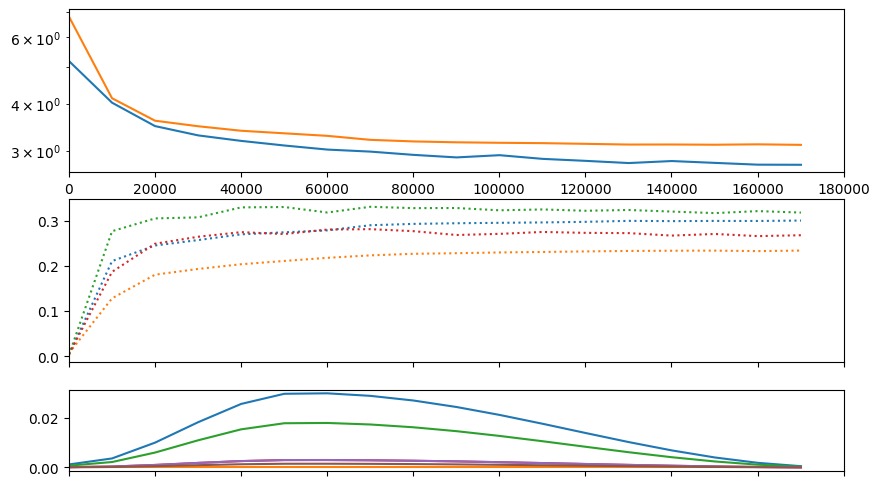

In [ ]:
# crossattn, emb 2Q, 400+ shards
train_ds, val_ds = load_datasets('s2a-small/*.tar.gz', samples=180000)
model = make_model('micro', quantizers=2, frozen_embeddings_model='vqmodel-4e-hyptuned-32gpu.model', dataset=train_ds).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)

192 32 4097


samples,train,val,time
50016,3.08482,3.07243,03:55
100000,2.85717,2.89056,07:51
150016,2.79573,2.80195,11:46
160000,2.79021,2.79402,12:33


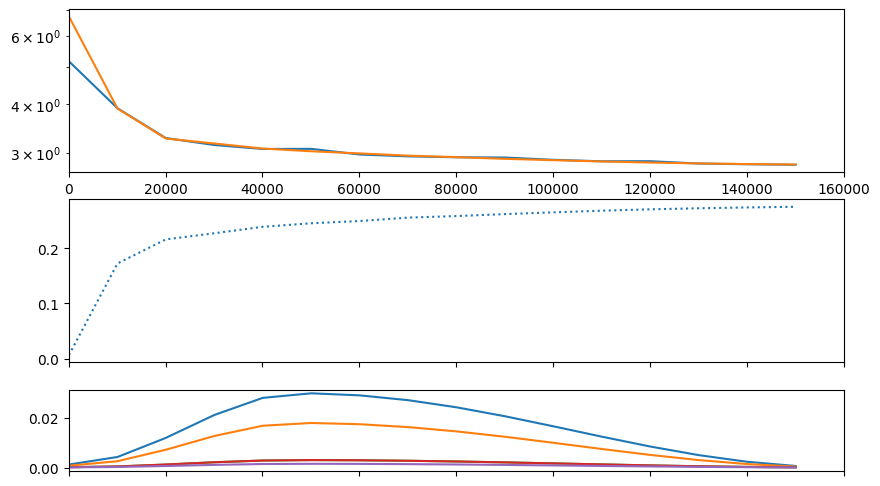

In [ ]:
# crossattn, emb all, 400+ shards
model = make_model('micro', quantizers=1, frozen_embeddings_model='vqmodel-4e-hyptuned-32gpu.model', dataset=train_ds).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)

192 32 4097


samples,train,val,time
50016,3.33196,3.38296,04:22
100000,3.10307,3.11948,08:44
150016,3.02954,3.01842,13:06
160000,2.97770,3.01012,13:58


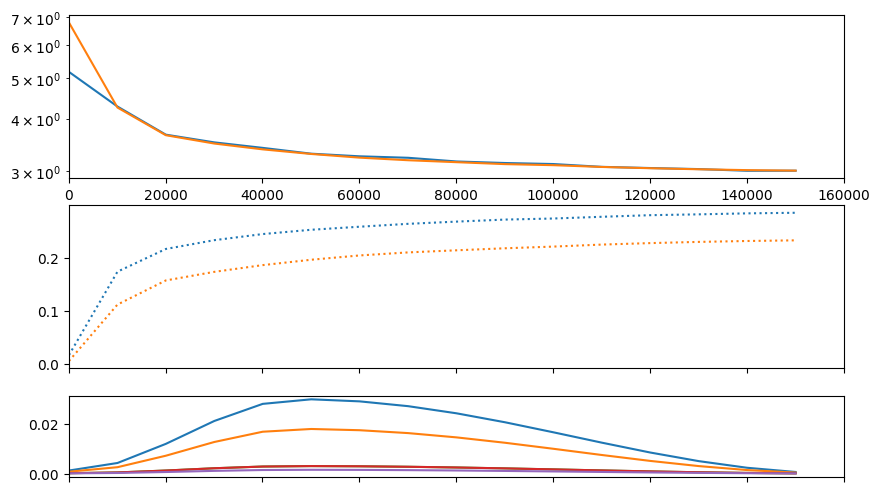

In [ ]:
# crossattn, emb 2Q, 400+ shards, linear heads
model = make_model('micro', quantizers=2, frozen_embeddings_model='vqmodel-4e-hyptuned-32gpu.model', dataset=train_ds, tunables=Tunables(linear_heads=True)).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)

192 32 4097


samples,train,val,time
50016,3.30979,3.40961,04:20
100000,3.10014,3.13427,08:39
150016,3.06509,3.03229,12:59
160000,3.05000,3.02330,13:51


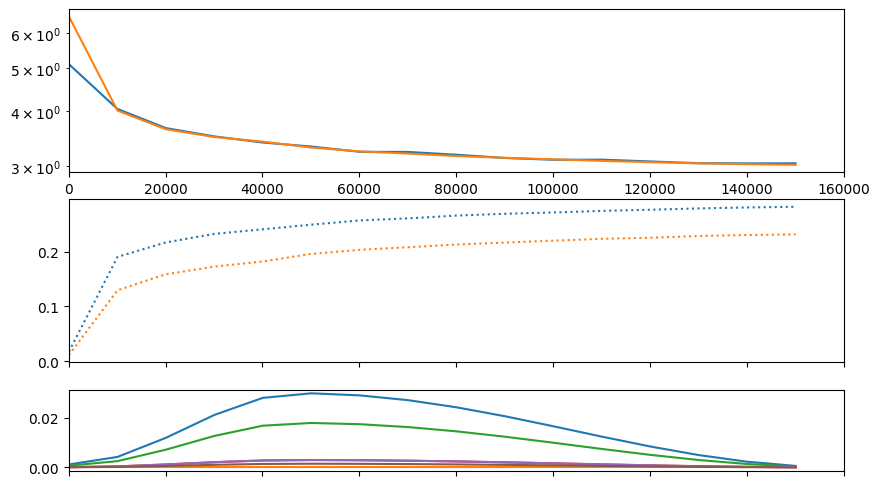

In [ ]:
# crossattn, emb 2Q, 400+ shards, linear heads
model = make_model('micro', quantizers=2, frozen_embeddings_model='vqmodel-4e-hyptuned-32gpu.model', dataset=train_ds, tunables=Tunables(linear_heads=True)).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)

192 32 4097


samples,train,val,time
50016,3.36395,3.41816,04:20
100000,3.10823,3.15187,08:39
150016,3.02961,3.04794,12:58
160000,3.05585,3.03891,13:50


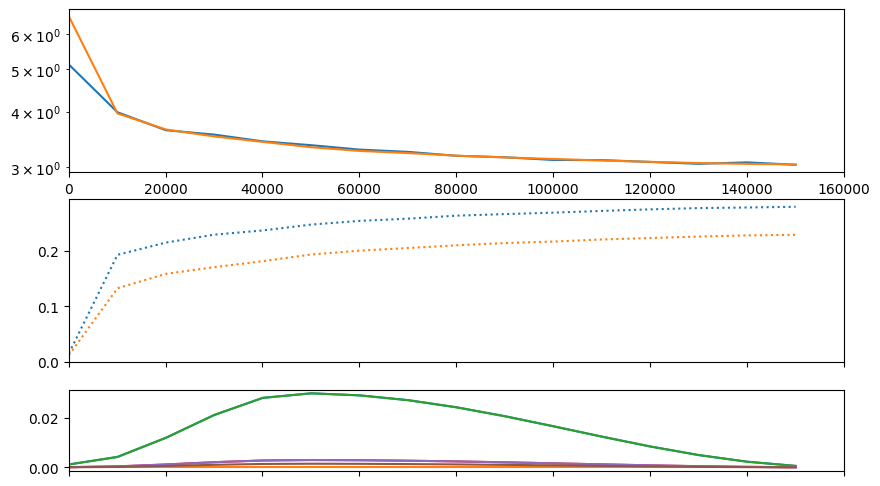

In [ ]:
# crossattn, emb 2Q, 400+ shards, linear heads, EmbProj lr=10
model = make_model('micro', quantizers=2, frozen_embeddings_model='vqmodel-4e-hyptuned-32gpu.model', dataset=train_ds, tunables=Tunables(linear_heads=True)).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)

192 32 4097


samples,train,val,time
50016,3.35115,3.42734,04:18
100000,3.14926,3.16296,08:37
150016,3.03723,3.05682,12:56
160000,3.05514,3.04801,13:48


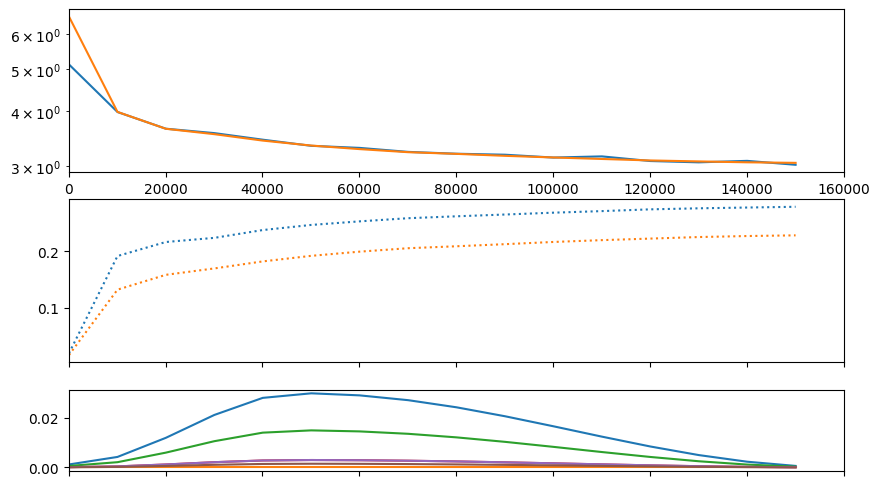

In [ ]:
# crossattn, emb 2Q, 400+ shards, linear heads, EmbProj lr=5
model = make_model('micro', quantizers=2, frozen_embeddings_model='vqmodel-4e-hyptuned-32gpu.model', dataset=train_ds, tunables=Tunables(linear_heads=True)).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)

192 32 4097


samples,train,val,time
50016,3.43349,3.51735,04:18
100000,3.20685,3.21835,08:36
150016,3.14143,3.11906,12:54
160000,3.12234,3.11243,13:45


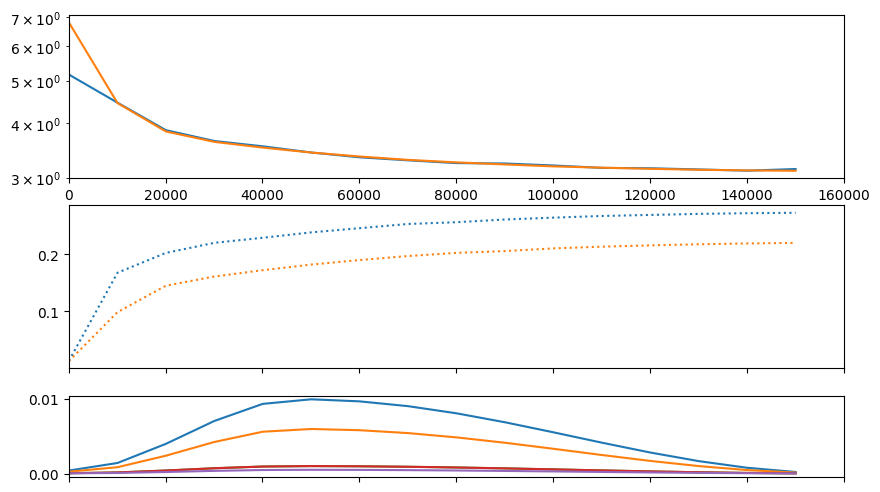

In [ ]:
# crossattn, emb 2Q, 400+ shards, linear heads
model = make_model('micro', quantizers=2, frozen_embeddings_model='vqmodel-4e-hyptuned-32gpu.model', dataset=train_ds, tunables=Tunables(linear_heads=True)).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=1e-3, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)

192 32 4097


samples,train,val,time
50016,3.73575,3.80450,05:12
100000,3.52139,3.51007,10:24
150016,3.38680,3.39870,15:36
160000,3.43426,3.39022,16:38


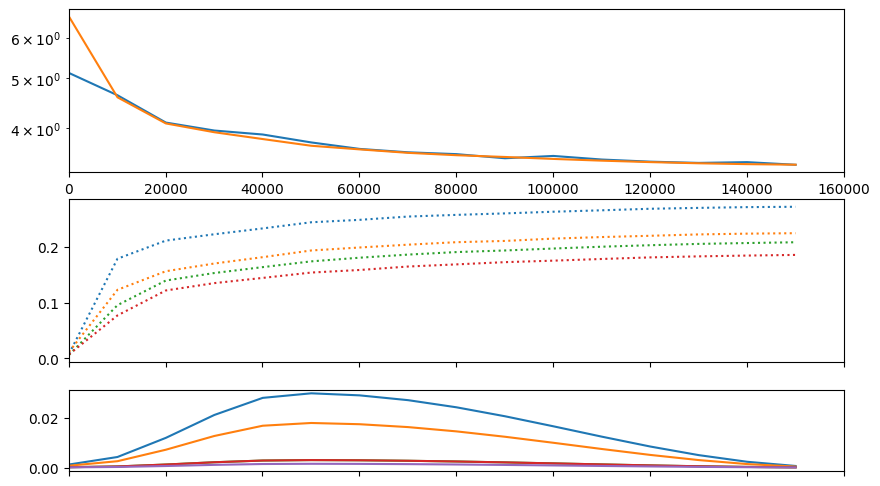

In [ ]:
# crossattn, emb 4Q, 400+ shards, linear heads
train_ds, val_ds = load_datasets('s2a-6454-4q/*.tar.gz', samples=160000)
model = make_model('micro', quantizers=4, frozen_embeddings_model='vqmodel-4e-hyptuned-32gpu.model', dataset=train_ds, tunables=Tunables(linear_heads=True)).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)

384 32 4097


samples,train,val,time
50016,3.19818,3.27087,09:27
100000,2.94915,2.98427,18:55
150016,2.85464,2.87508,28:22
160000,2.82709,2.86586,30:15


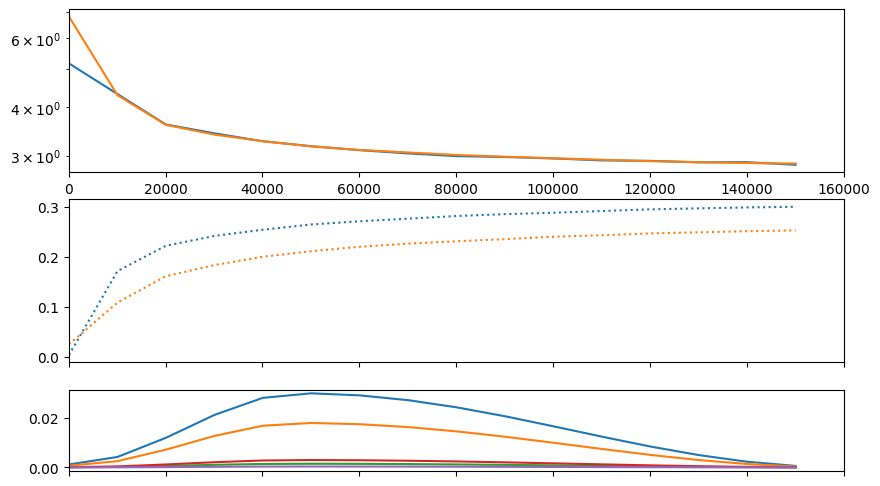

In [ ]:
# crossattn, emb 2Q
model = make_model('tiny', quantizers=2, frozen_embeddings_model='vqmodel-4e-hyptuned-32gpu.model', dataset=train_ds).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)
model.save_model('s2a-tiny-wds-cross.model')

384 64 513


samples,train,val,time
50016,3.09247,3.59736,09:29
100000,2.92941,3.28088,18:58
150016,2.87256,3.16761,28:27
200000,2.77072,3.07312,37:56
200928,2.80928,3.07167,38:18


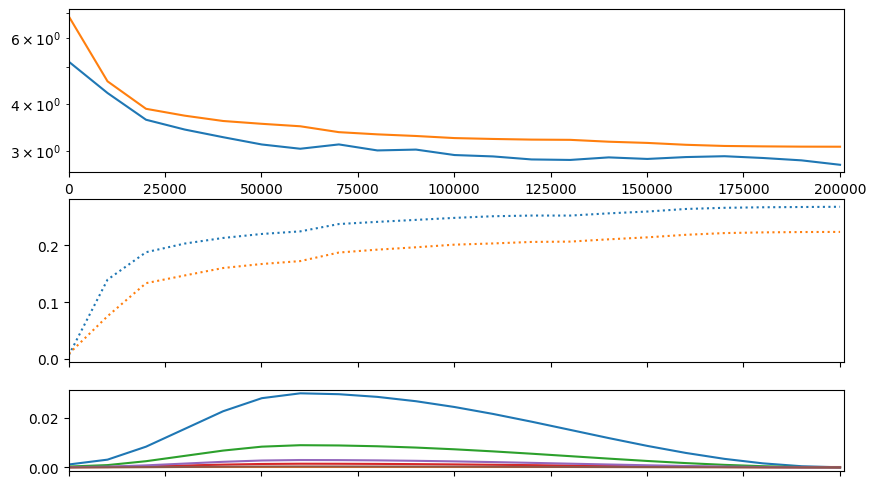

In [ ]:
train_ds, val_ds = load_datasets('whisperspeech-s2a-512c-dim64/*.tar.gz', samples=67000, stoks_pad_token=512)
model = make_model('tiny', quantizers=2, frozen_embeddings_model='vqmodel-256c-dim64-4e-hyptuned-32gpu.model', dataset=train_ds).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=3, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)
model.save_model('s2a-512c-dim64-tiny-wds-cross-6454.model')

384 32 513


samples,train,val,time
64,5.18270,0.00000,00:01


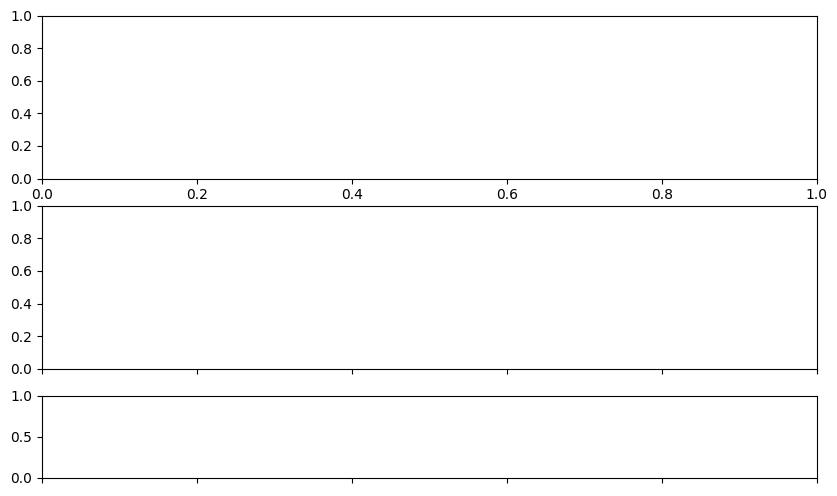

In [ ]:
train_ds, val_ds = load_datasets('whisperspeech-s2a-512c/*.tar.gz', samples=67000, stoks_pad_token=512)
model = make_model('tiny', quantizers=2, frozen_embeddings_model='vqmodel-256c-4e-hyptuned-32gpu.model', dataset=train_ds).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=3, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)
model.save_model('s2a-512c-tiny-wds-cross-6454.model')

384 32 4097


samples,train,val,time
50016,3.55823,3.63592,10:22
100000,3.24530,3.29306,20:43
150016,3.12748,3.16482,31:04
160000,3.15143,3.15668,33:08


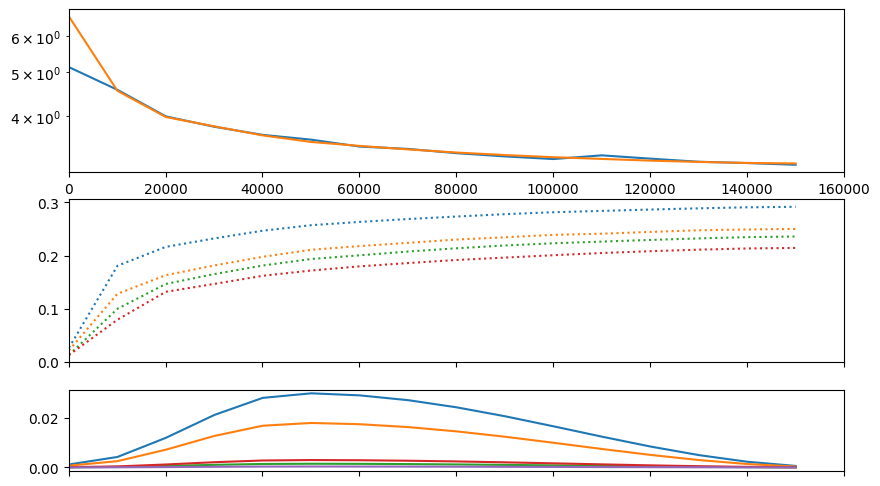

In [ ]:
# crossattn, emb 4Q, 400+ shards, linear heads
train_ds, val_ds = load_datasets('s2a-6454-4q/*.tar.gz', samples=160000)
model = make_model('tiny', quantizers=4, frozen_embeddings_model='vqmodel-4e-hyptuned-32gpu.model', dataset=train_ds, tunables=Tunables(linear_heads=True)).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)
model.save_model('s2a-tiny-4q-wds-cross.model')

192 32 4097


samples,train,val,time
50016,4.38294,4.82997,03:52
100000,4.36976,4.85217,07:45
150016,4.48648,4.69173,11:37
160000,4.53327,4.65840,12:23


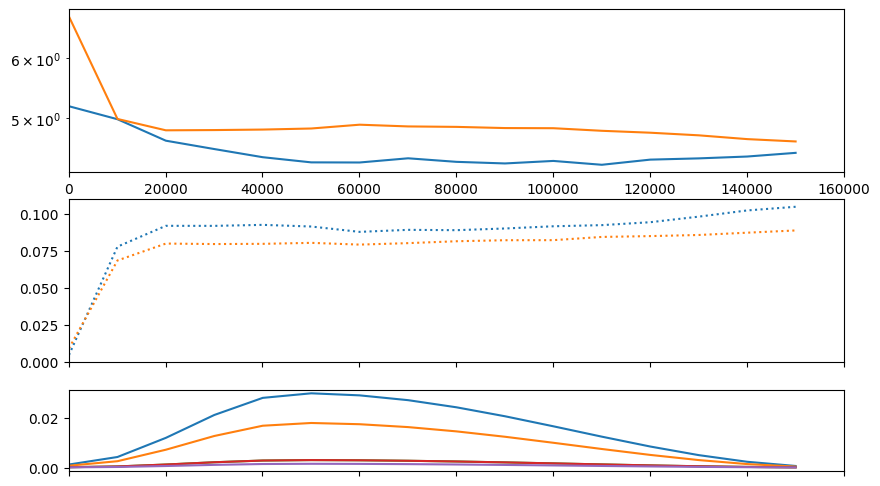

In [ ]:
# no xenc, emb 2Q
model = make_model('micro', quantizers=2, frozen_embeddings_model='vqmodel-4e-hyptuned-32gpu.model', dataset=train_ds).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)

192 32 4097


samples,train,val,time
50016,3.74297,4.20712,03:51
100000,3.65669,4.04836,07:42
150016,3.72150,3.91123,11:33
160000,3.74524,3.89218,12:19


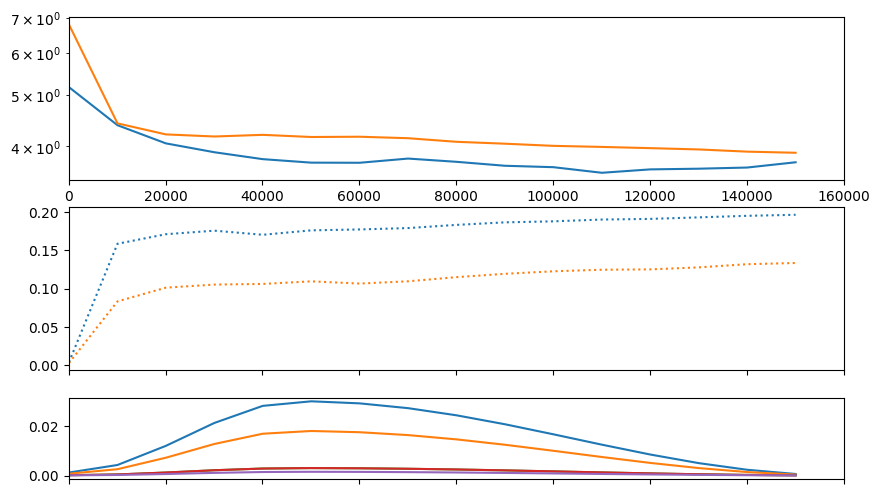

In [ ]:
# no xenc, emb 1Q
model = make_model('micro', quantizers=2, frozen_embeddings_model='vqmodel-4e-hyptuned-32gpu.model', dataset=train_ds).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)

192 32 4097


samples,train,val,time
50016,3.34288,4.00282,03:49
100000,3.27247,3.88112,07:38
150016,3.39283,3.73514,11:27
160000,3.46310,3.71837,12:13


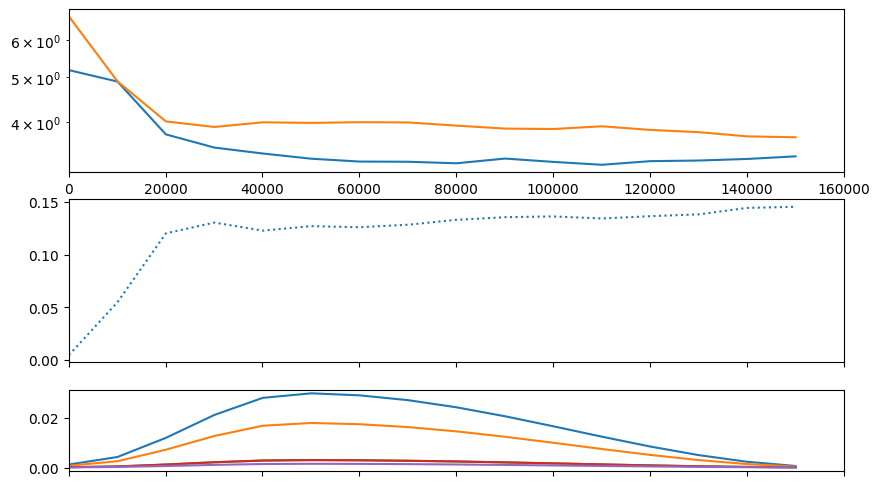

In [ ]:
# cross, 1q, don't embed Q1 ;)
model = make_model('micro', quantizers=1, frozen_embeddings_model='vqmodel-4e-hyptuned-32gpu.model', dataset=train_ds).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)

192 32 4097


samples,train,val,time
50016,2.86980,3.44263,03:50
100000,2.82082,3.44939,07:41
150016,3.00885,3.20670,11:32
160000,3.04030,3.16246,12:18


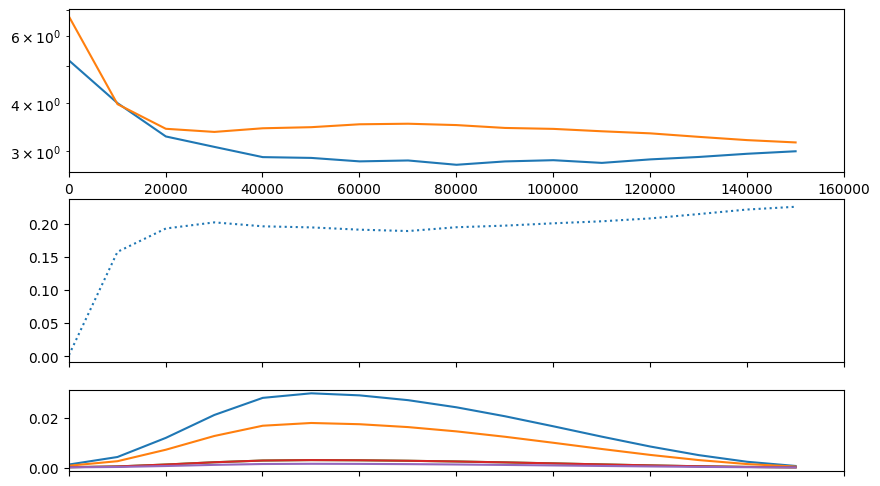

In [ ]:
# cross, 1q
model = make_model('micro', quantizers=1, frozen_embeddings_model='vqmodel-4e-hyptuned-32gpu.model', dataset=train_ds).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)

192 32 4097


samples,train,val,time
50016,3.67311,4.19860,04:16
100000,3.67140,4.10176,08:31
150016,3.73631,3.94144,12:47
160000,3.73755,3.91028,13:38


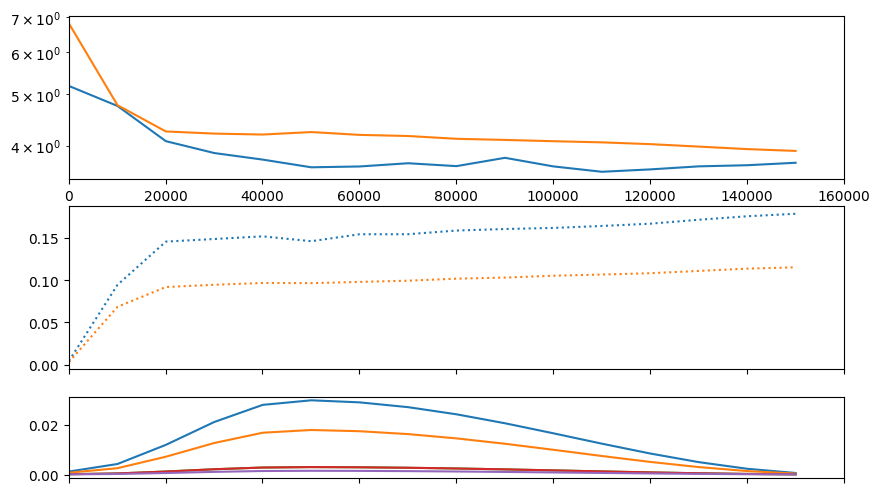

In [ ]:
# crossattn, emb 2Q (replace, not add)
model = make_model('micro', quantizers=2, frozen_embeddings_model='vqmodel-4e-hyptuned-32gpu.model', dataset=train_ds).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)

In [ ]:
s2a = make_model('base', quantizers=2, frozen_embeddings_model='vqmodel-512c-dim64-4e-hyptuned-32gpu.model', dataset=train_ds)
s2a.load_checkpoint('vital-dust-70.ckpt')
s2a.save_model('s2a-base-wds-cross-4e.model')

512 64 513


In [ ]:
s2a = make_model('base', quantizers=2, spk_width=192, frozen_embeddings_model='old-models/vqmodel-512c-dim64-4e-hyptuned-32gpu.model')
s2a.load_checkpoint('../s2a_delar_mup_wds-epoch=2-step=10591-val_loss=0.00.ckpt')
s2a.save_model('s2a-base-spkemb-gutenberg.model')

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 s2a = make_model('base', quantizers=2, spk_width=192, frozen_embeddings_model='old-model     │
│ ❱ 2 s2a.load_checkpoint('../s2a_delar_mup_wds-epoch=2-step=10591-val_loss=0.00.ckpt')            │
│   3 s2a.save_model('s2a-base-spkemb-gutenberg.model')                                            │
│   4                                                                                              │
│                                                                                                  │
│ in load_checkpoint:276                                                                           │
│                                                                                                  │
│   273 │   │   assert 'pytorch-lightning_version' in spec, 'not a valid PyTorch Lightning check   │
│   274 │   │   state_dict = {k.replace('model.', ''):v                                            │
│   275 │   │   │   │   │     for k,v in spec['state_dict'].items()}                               │
│ ❱ 276 │   │   self.load_state_dict(state_dict)                                                   │
│   277 │   │   return self                                                                        │
│   278 │                                                                                          │
│   279 │   def save_model(self, fname):                                                           │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:2041 in load_state_dict       │
│                                                                                                  │
│   2038 │   │   │   │   │   │   ', '.join('"{}"'.format(k) for k in missing_keys)))               │
│   2039 │   │                                                                                     │
│   2040 │   │   if len(error_msgs) > 0:                                                           │
│ ❱ 2041 │   │   │   raise RuntimeError('Error(s) in loading state_dict for {}:\n\t{}'.format(     │
│   2042 │   │   │   │   │   │   │      self.__class__.__name__, "\n\t".join(error_msgs)))         │
│   2043 │   │   return _IncompatibleKeys(missing_keys, unexpected_keys)                           │
│   2044                                                                                           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
RuntimeError: Error(s) in loading state_dict for SADelARTransformer:
        Missing key(s) in state_dict: "emb_to_hidden.weight", "emb_to_hidden.bias". 
        size mismatch for semantic_embedding.weight: copying a param with shape torch.Size([4097, 512]) from 
checkpoint, the shape in current model is torch.Size([513, 64]).